In [41]:
import json
import os

import matplotlib.pyplot as plt
import pandas as pd

In [42]:
data_dir = './assets/results_with_latency'
files = [f for f in os.listdir(data_dir) if f.endswith('.json')]
metrics_data = {}

for file in files:
    method = file.split('.')[0]
    with open(os.path.join(data_dir, file), 'r') as f:
        data = json.load(f)
        metrics_data[method] = data

nodes = set()
for method_data in metrics_data.values():
    nodes.update(method_data['cpu'].keys())
nodes = sorted(list(nodes))

In [43]:
latency_by_node = {}
cpu_percentage_by_node = {}
cpu_count_by_node = {}
mem_percentage_by_node = {}
mem_count_by_node = {}
makespan_by_wave = {}
total_makespan = {}

for method, d in metrics_data.items():
    for node, val in d["avg_latency_ms_by_port"].items():
        latency_by_node.setdefault(node, {})[method] = val

    makespan_by_wave[method] = d["per_wave_makespan_s"]

    total_makespan[method] = d["total_makespan_s"]

    for node, v in d["cpu_avg_percentage"].items():
        cpu_percentage_by_node.setdefault(node, {})[method] = v * 100
    for node, v in d["mem_avg_percentage"].items():
        mem_percentage_by_node.setdefault(node, {})[method] = v * 100

    for node, v in d["cpu"].items():
        cpu_count_by_node.setdefault(node, {})[method] = v
    for node, v in d["mem"].items():
        mem_count_by_node.setdefault(node, {})[method] = v

latency_df = pd.DataFrame(latency_by_node).T.loc[nodes]
cpu_percentage_df = pd.DataFrame(cpu_percentage_by_node).T.loc[nodes]
mem_percentage_df = pd.DataFrame(mem_percentage_by_node).T.loc[nodes]
cpu_count_df      = pd.DataFrame(cpu_count_by_node).T.reindex(nodes)
mem_count_df      = pd.DataFrame(mem_count_by_node).T.reindex(nodes)
makespan_df = pd.DataFrame(makespan_by_wave)
total_df = pd.Series(total_makespan).to_frame("total_s")

In [44]:
def get_uniform_distribution(df):
    total = df.sum().mean()
    uniform_value = total / len(df)
    return pd.Series([uniform_value] * len(df), index=df.index, name='uniform')


cpu_percentage_by_node_uniform = cpu_percentage_df.copy()
cpu_percentage_by_node_uniform['uniform'] = get_uniform_distribution(cpu_percentage_df)
mem_percentage_by_node_uniform = mem_percentage_df.copy()
mem_percentage_by_node_uniform['uniform'] = get_uniform_distribution(mem_percentage_df)

cpu_count_by_node_uniform = cpu_count_df.copy()
cpu_count_by_node_uniform['uniform'] = get_uniform_distribution(cpu_count_df)
mem_count_by_node_uniform = mem_count_df.copy()
mem_count_by_node_uniform['uniform'] = get_uniform_distribution(mem_count_df)

<Figure size 1600x600 with 0 Axes>

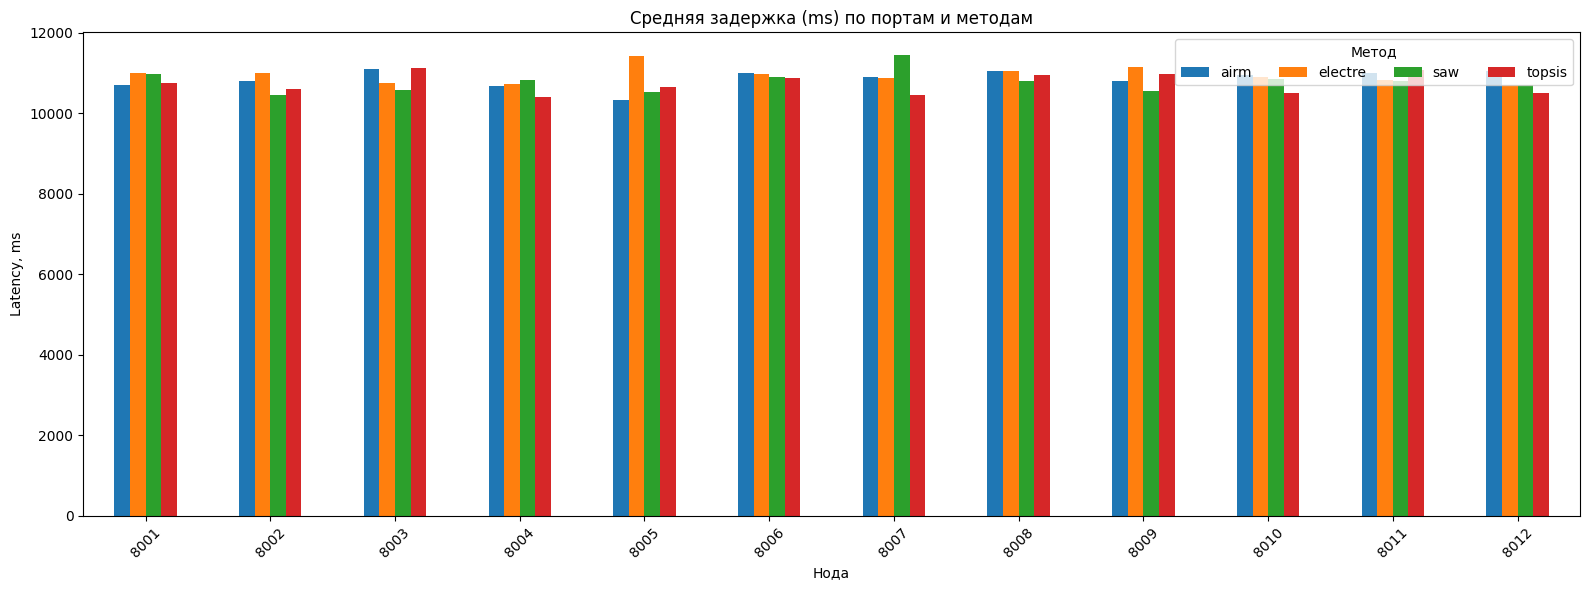

In [45]:
# --------------------------------------------------------------------------- #
#  1. Средняя задержка по портам                                              #
# --------------------------------------------------------------------------- #
plt.figure(figsize=(16, 6))
latency_df.plot(kind="bar", figsize=(16, 6))
plt.title("Средняя задержка (ms) по портам и методам")
plt.xlabel("Нода"), plt.ylabel("Latency, ms")
plt.xticks(rotation=45)
plt.legend(title="Метод", ncol=len(latency_df.columns))
plt.tight_layout()
plt.show()

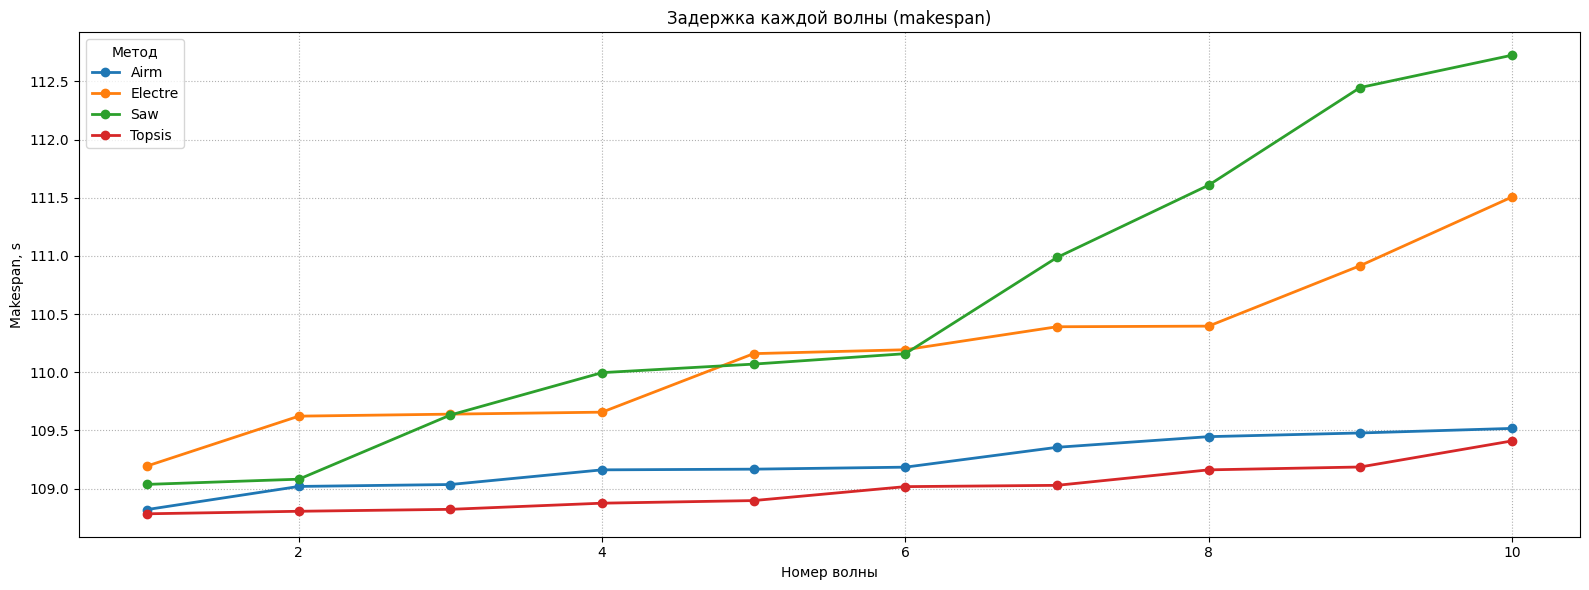

In [46]:
# --------------------------------------------------------------------------- #
#  2. Makespan каждой волны                                                   #
# --------------------------------------------------------------------------- #
plt.figure(figsize=(16, 6))
for method in makespan_df.columns:
    plt.plot(makespan_df.index + 1,  # сделать ось X «волна 1…N»
             makespan_df[method],
             marker="o", linewidth=2, label=method.capitalize())
plt.title("Задержка каждой волны (makespan)")
plt.xlabel("Номер волны"), plt.ylabel("Makespan, s")
plt.grid(True, linestyle=":")
plt.legend(title="Метод")
plt.tight_layout()
plt.show()

<Figure size 1600x600 with 0 Axes>

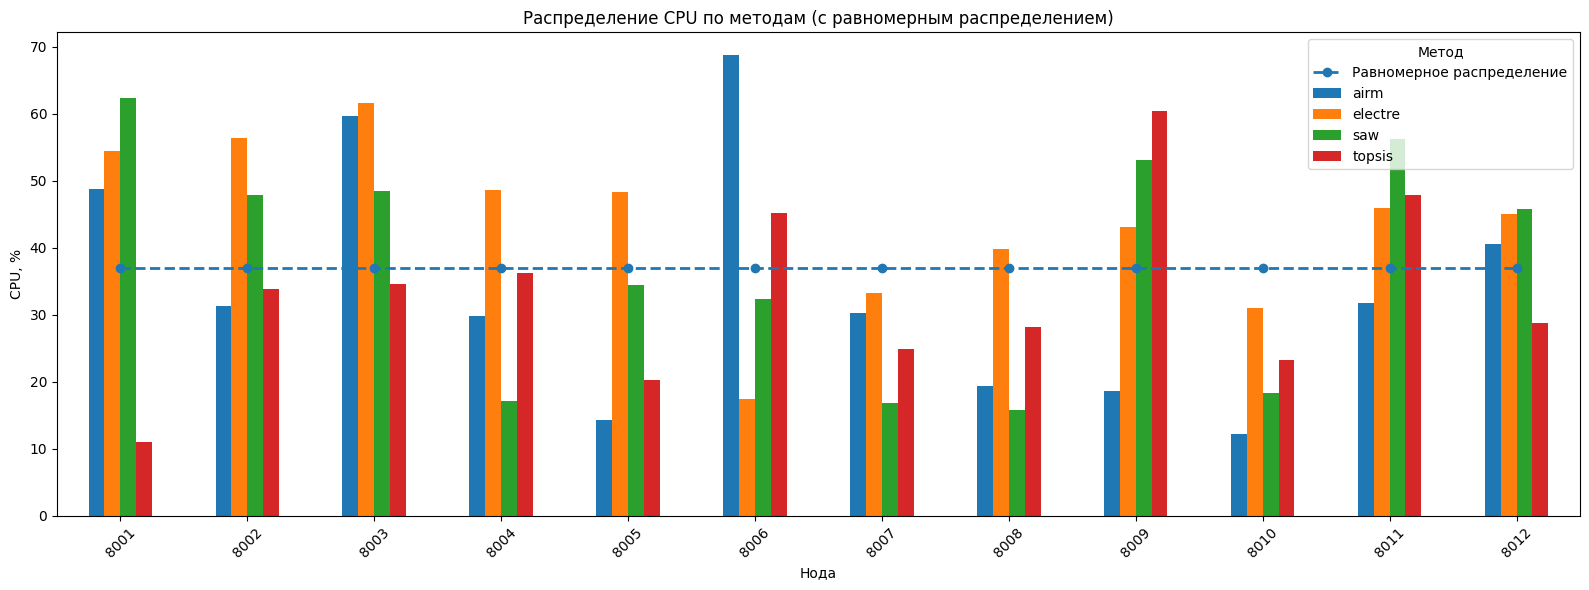

<Figure size 1600x600 with 0 Axes>

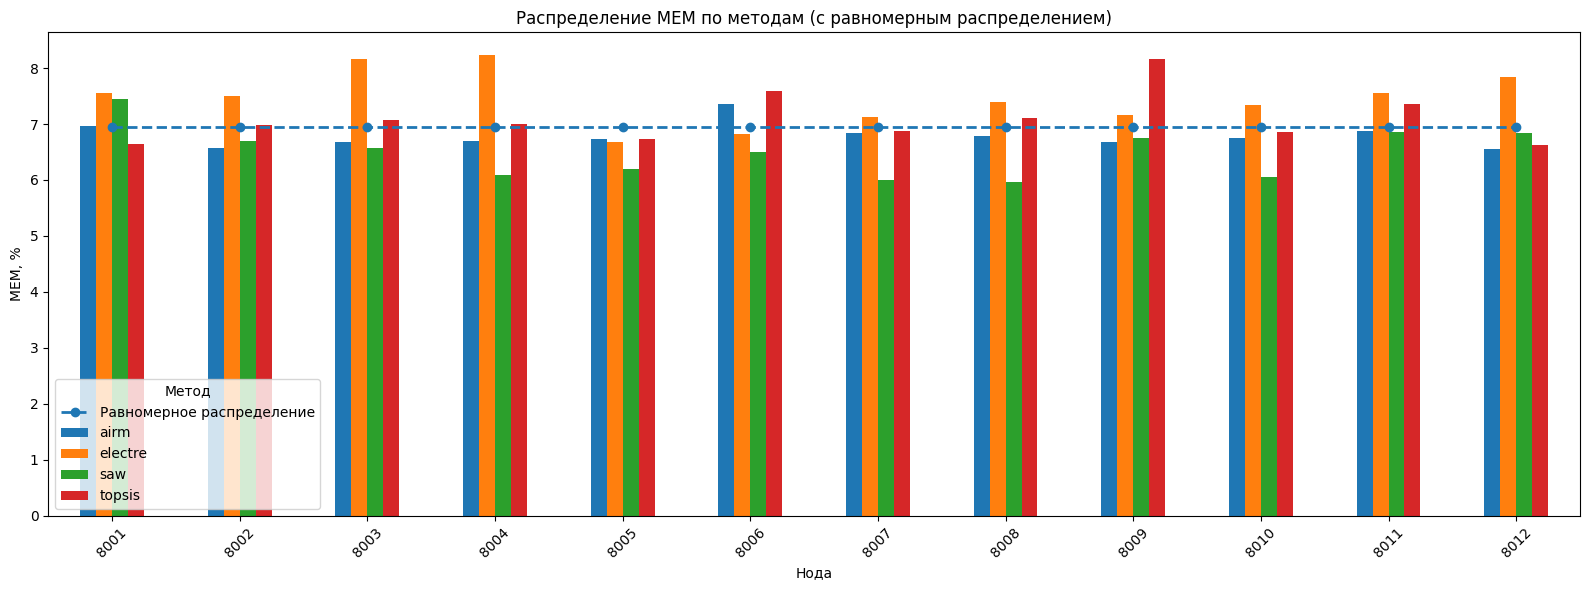

In [47]:
# --------------------------------------------------------------------------- #
#  3. CPU % распределение                                                     #
# --------------------------------------------------------------------------- #
plt.figure(figsize=(16, 6))
cpu_percentage_df.plot(kind="bar", figsize=(16, 6))
plt.plot(cpu_percentage_df.index, cpu_percentage_by_node_uniform['uniform'], linestyle='--', marker='o',
         label='Равномерное распределение', linewidth=2)
plt.title("Распределение CPU по методам (с равномерным распределением)")
plt.xlabel("Нода"), plt.ylabel("CPU, %")
plt.xticks(rotation=45)
plt.legend(title="Метод")
plt.tight_layout()
plt.show()

# --------------------------------------------------------------------------- #
#  4. MEM % распределение                                                     #
# --------------------------------------------------------------------------- #
plt.figure(figsize=(16, 6))
mem_percentage_df.plot(kind="bar", figsize=(16, 6))
plt.plot(cpu_percentage_df.index, mem_percentage_by_node_uniform['uniform'], linestyle='--', marker='o',
         label='Равномерное распределение', linewidth=2)
plt.title("Распределение MEM по методам (с равномерным распределением)")
plt.xlabel("Нода"), plt.ylabel("MEM, %")
plt.xticks(rotation=45)
plt.legend(title="Метод")
plt.tight_layout()
plt.show()

<Figure size 1600x600 with 0 Axes>

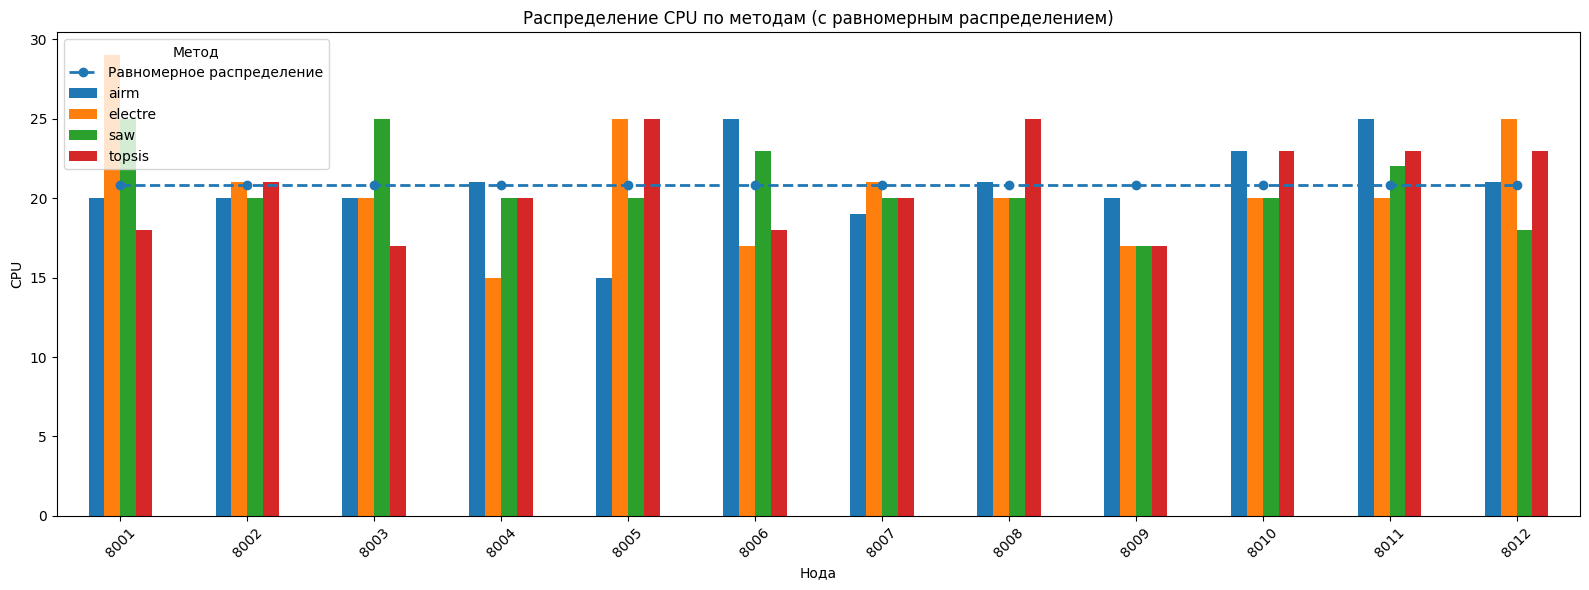

<Figure size 1600x600 with 0 Axes>

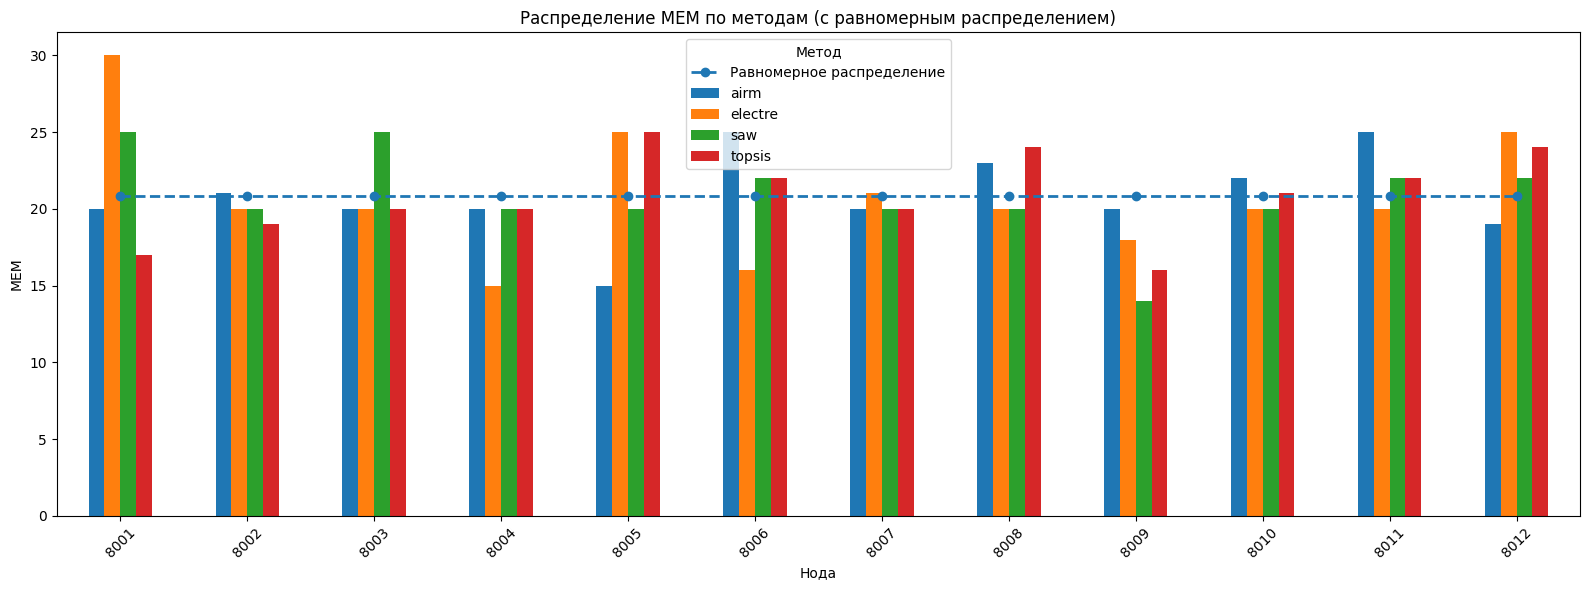

In [48]:
# --------------------------------------------------------------------------- #
#  5. CPU распределение                                                       #
# --------------------------------------------------------------------------- #
plt.figure(figsize=(16, 6))
cpu_count_df.plot(kind='bar', figsize=(16, 6))
plt.plot(cpu_percentage_df.index, cpu_count_by_node_uniform['uniform'], linestyle='--', marker='o',
         label='Равномерное распределение',
         linewidth=2)
plt.title('Распределение CPU по методам (с равномерным распределением)')
plt.xlabel('Нода')
plt.ylabel('CPU')
plt.xticks(rotation=45)
plt.legend(title='Метод')
plt.tight_layout()
plt.show()

# --------------------------------------------------------------------------- #
#  6. MEM распределение                                                       #
# --------------------------------------------------------------------------- #
plt.figure(figsize=(16, 6))
mem_count_df.plot(kind='bar', figsize=(16, 6))
plt.plot(mem_percentage_df.index, mem_count_by_node_uniform['uniform'], linestyle='--', marker='o',
         label='Равномерное распределение',
         linewidth=2)
plt.title('Распределение MEM по методам (с равномерным распределением)')
plt.xlabel('Нода')
plt.ylabel('MEM')
plt.xticks(rotation=45)
plt.legend(title='Метод')
plt.tight_layout()
plt.show()

<Figure size 800x400 with 0 Axes>

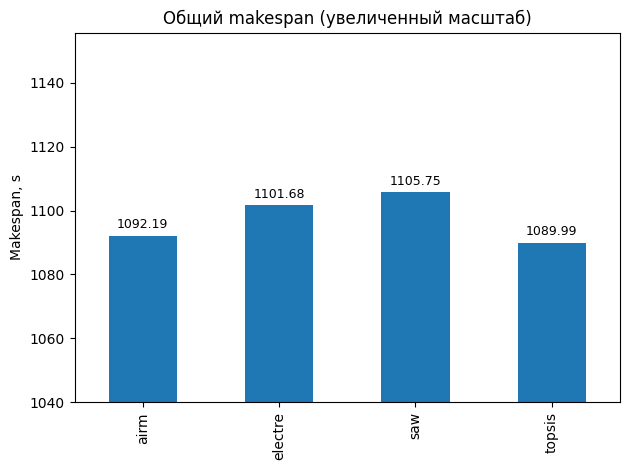

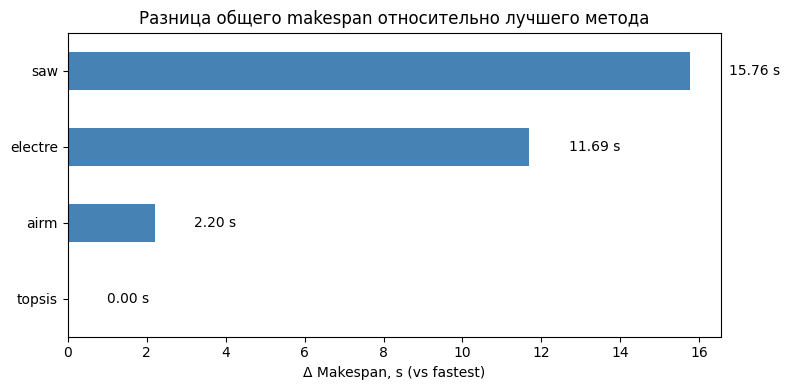

In [49]:
# --------------------------------------------------------------------------- #
#  7.1. Тот же bar, но с «приближённой» осью                                   #
# --------------------------------------------------------------------------- #
plt.figure(figsize=(8, 4))

ax = total_df.plot(kind="bar", legend=False)
best, worst = total_df["total_s"].min(), total_df["total_s"].max()

ax.set_ylim(best - 50, worst + 50)
plt.title("Общий makespan (увеличенный масштаб)")
plt.ylabel("Makespan, s")

for p in ax.patches:
    val = p.get_height()
    ax.annotate(f"{val:.2f}",
                xy=(p.get_x() + p.get_width() / 2, val),
                xytext=(0, 3), textcoords="offset points",
                ha="center", va="bottom", fontsize=9)
plt.tight_layout()
plt.show()


# --------------------------------------------------------------------------- #
#  7.2. delta-makespan относительно лучшего метода                                 #
# --------------------------------------------------------------------------- #
plt.figure(figsize=(8, 4))

delta = (total_df["total_s"] - total_df["total_s"].min()).sort_values()

delta.plot(kind="barh", color="steelblue")
plt.xlabel("Δ Makespan, s (vs fastest)")
plt.title("Разница общего makespan относительно лучшего метода")

for idx, val in enumerate(delta):
    plt.text(val + 1, idx, f"{val:.2f} s", va="center")

plt.tight_layout()
plt.show()
